## Project Beer reviews 
### Group SustainablePandas
Groups members: Bastien Amez-Droz, Noé Fellay, Nicolas Frédéric Rochat, Baptiste Michel \
TA: Halima Schede

### Libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import tarfile
import gzip
import shutil

import seaborn as sns
import math
import matplotlib
import pandas as pd
import os
import numpy as np


### Uncompress folders and files

In [2]:
def ungzip_folder(FOLDER_NAME):
    """
    This function allows to extract datas from gzip folder into a new accessible folder
    - FOLDER_NAME: name of the folder to create from the gzip folder
    The function returns nothing, it only creates the new folder
    """
    FOLDER_PATH = './Data/' + FOLDER_NAME
    
    #check if folder is already unzipped
    if os.path.exists(FOLDER_PATH) == False:
    
        # open folder
        folder = tarfile.open(FOLDER_PATH + '.tar.gz',"r:gz")
        # extracting folder
        folder.extractall(FOLDER_PATH)
        # closing folder
        folder.close()

In [3]:
ungzip_folder("RateBeer")

In [4]:
def ungzip_txt_file(FOLDER_NAME, FILE_NAME):
    """
    This function allows to extract datas from gzip file into a new accessible file
    - FOLDER_NAME: name of the folder in which the gzip file is
    - FILE_NAME: name of the file to create from the gzip file
    The function returns nothing, it only creates the new file
    """
    FILE_PATH = './Data/' + FOLDER_NAME + '/' + FILE_NAME
    
    #check if file is already unzipped
    if os.path.exists(FILE_PATH) == False:
    
        with gzip.open(FILE_PATH + '.gz', 'r') as f_in:
            with open(FILE_PATH, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

In [5]:
ungzip_txt_file("RateBeer","ratings.txt")
ungzip_txt_file("RateBeer","reviews.txt")

### Extract infos from txt files

In [6]:
def txt_to_dataframe(FOLDER_NAME,TXT_FILE_NAME,keys_list):
    """
    This function allows to pass the txt file to a dataframe
    - FOLDER_NAME: name of the folder in which the txt file is
    - TXT_FILE_NAME: text file with a dictionary format
    - keys_list: list of keys for the columns
    The function returns a dataframe file
    """
    dict_list = []
    newDict = {key: None for key in keys_list}
    
    FILE_PATH = './Data/' + FOLDER_NAME + '/' + TXT_FILE_NAME

    with open(FILE_PATH, 'r', encoding="utf8") as f:
    
        for line in f:
            line = line.replace(u'\xa0','')
            listedline = line.split(':',1) # split around the ":" sign
        
            # take non-empty lines
            if len(listedline) > 1:
                newDict[listedline[0]] = listedline[1].strip()
        
            # finish the dictionary for the line
            if listedline[0] == keys_list[-1]:
                dict_list.append(newDict)
            
                # reinitialize the dictionary for the next line
                newDict = {key: None for key in keys_list}
    
        # transform list of dictionaries to dataframe
        df = pd.DataFrame(dict_list,columns=keys_list)    
    
    return df

In [7]:
keys_reviews = (['beer_name','beer_id','brewery_name','brewery_id','style','abv','date','user_name','user_id',\
                          'appearance','aroma','palate','taste','overall','rating','text'])

df_reviews_RB = txt_to_dataframe("RateBeer","reviews.txt",keys_reviews)

In [8]:
df_reviews_RB.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,1461664800,Manslow,175852,2,4,2,4,8,2.00,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1487329200,MAGICuenca91,442761,2,3,2,4,8,1.90,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1466762400,Sibarh,288889,3,3,2,3,5,1.60,"Kolor- złoty, klarowny. Piana - drobna, średni..."
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1451646000,fombe89,250510,4,3,1,2,5,1.50,"Botella, de GabÃ³n regalo familiar.31/01/2015C..."
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,1445594400,kevnic2008,122778,2,4,2,4,7,1.90,Many thanks for this beer to Erzengel. Pours l...


### Extract infos from csv files

In [9]:
df_beers_RB = pd.read_csv("./Data/RateBeer/beers.csv")
df_users_RB = pd.read_csv("./Data/RateBeer/users.csv")
df_breweries_RB = pd.read_csv("./Data/RateBeer/breweries.csv")

df_breweries_RB.rename(columns={"id": "brewery_id"}, inplace=True)

In [11]:
df_users_RB.head()

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland
3,3371,250510,fombe89,1.363950e+09,Spain
4,13043,122778,kevnic2008,1.296644e+09,Germany


### Create a dataframe for further analyses

Dataframe format: &emsp; beer_name | beer_id | brewery_id | date | rating | user_location | brewery_location

In [23]:
# merge reviews and users on user infos
df_reviews_RB['user_id'] = df_reviews_RB['user_id'].astype(int)
df_reviews_RB['brewery_id'] = df_reviews_RB['brewery_id'].astype(int)

df_reviews_users_RB=pd.merge(df_reviews_RB, df_users_RB, how="left", on=['user_name','user_id'])
df_all_RB = pd.merge(df_reviews_users_RB,df_breweries_RB, how='left', on=['brewery_id'])

# keep only keys of interest
df_interest_RB= df_all_RB.drop(['style', 'abv', 'appearance', 'user_id', 'aroma', 'palate', 'taste', 'text', 'brewery_name', 'user_name', 'overall', 'nbr_ratings', 'joined', 'name', 'nbr_beers'], axis=1)

# rename location variables
df_interest_RB.rename(columns={"location_x": "user_location"}, inplace=True)
df_interest_RB.rename(columns={"location_y": "brewery_location"}, inplace=True)

# set time variable
df_interest_RB['date'] = pd.to_datetime(df_interest_RB['date'], unit='s')

In [24]:
df_interest_RB.head()

,beer_name,beer_id,brewery_id,date,rating,user_location,brewery_location
0,33 Export (Gabon),410549,3198,2016-04-26 10:00:00,2.00,Poland,Gabon
1,Castel Beer (Gabon),105273,3198,2017-02-17 11:00:00,1.90,Spain,Gabon
2,Castel Beer (Gabon),105273,3198,2016-06-24 10:00:00,1.60,Poland,Gabon
3,Castel Beer (Gabon),105273,3198,2016-01-01 11:00:00,1.50,Spain,Gabon
4,Castel Beer (Gabon),105273,3198,2015-10-23 10:00:00,1.90,Germany,Gabon


### Histogram of reviews over time

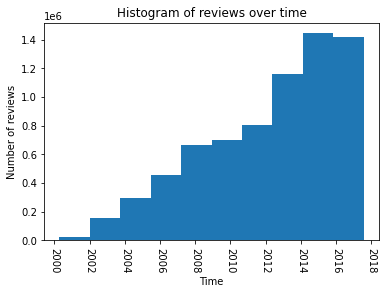

In [25]:
# Histogram of reviews over time
plt.hist(df_interest_RB['date'])

plt.title("Histogram of reviews over time")
plt.xlabel("Time")
plt.xticks(rotation=270)
plt.ylabel("Number of reviews")
plt.show()

### Reviews per county of US and country

In [26]:
# split user location into country and county
df_interest_RB[["user_country","user_county"]] = df_interest_RB['user_location'].str.split(pat = ', ', expand = True)
df_interest_RB.fillna("",inplace=True)

# create a dataframe on counties from United States
Num_county = df_interest_RB.groupby(["user_country","user_county"])["user_county"].count()
Num_county = Num_county["United States"]
df_county = Num_county.to_frame()
df_county.rename(columns = {'user_county':'reviews'}, inplace = True)

# create a dataframe on countries
Num_country = df_interest_RB.groupby(["user_country"])["user_country"].count()
df_country = Num_country.to_frame()
df_country.rename(columns = {'user_country':'reviews'}, inplace = True)

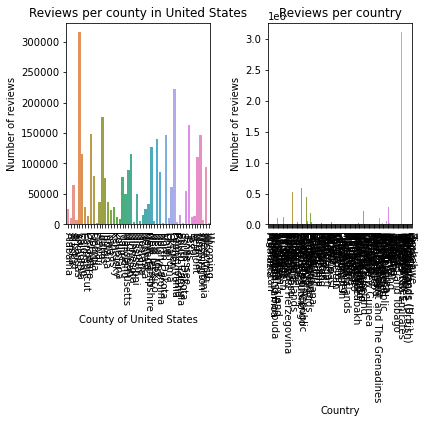

In [29]:
# Plot of reviews per county in US
plt.subplot(121)
sns.barplot(x = df_county.index, y="reviews",data=df_county)

plt.title("Reviews per county in United States")
plt.xlabel("County of United States")
plt.xticks(rotation=270)
plt.ylabel("Number of reviews")

# Plot of reviews per country
plt.subplot(122)
sns.barplot(x = df_country.index, y="reviews",data=df_country)

plt.title("Reviews per country")
plt.xlabel("Country")
plt.xticks(rotation=270)
plt.ylabel("Number of reviews")

plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

### Breweries per location

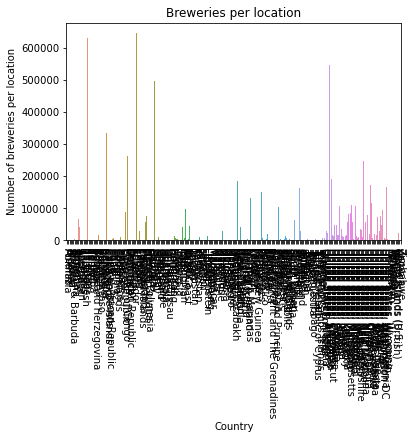

In [31]:
Num_brewery = df_interest_RB.groupby('brewery_location')['brewery_location'].count()
df_brewery = Num_brewery.to_frame()
df_brewery.rename(columns = {'brewery_location':'breweries'}, inplace = True)

# Plot of breweries per location
sns.barplot(x = Num_brewery.index, y="breweries",data=df_brewery)

plt.title("Breweries per location")
plt.xlabel("Country")
plt.xticks(rotation=270)
plt.ylabel("Number of breweries per location")
plt.show()